# Optimization study 3: phenol alkylation

This is the script we used for the optimization of phenol alkylation reactions. The results are also analyzed

## Decide on the reaction scope

We first decided on the reaction scope.
- Substrates:
    - 5 phenols, 5 mesylates
    - 1 phenol (p5) and 1 mesylate (m1) left out as external substrate
- Conditions:
    - 6 bases, 2 solvents, 3 temperatures

![scope](https://raw.githubusercontent.com/beef-broccoli/misc-files/main/deebo/phenol%20alkylation%20scope.png)

## Featurize molecules in scope

The next thing to do is to featurize the molecules in the scope for the prediction model. This espeically makes sense for substrate molecules to increase the prediction accuracy. The simplest way to featurize substrates, without making assumptions about their individual reactivities, is to describe the structural features with molecular fingerprints. 

For example, we can use the following function, which featurizes a list of SMILES strings into a .csv file of Morgan fingerprints using rdkit.

In [1]:
import numpy as np
import pandas as pd
from rdkit.Chem import PandasTools
from rdkit.Chem.rdMolDescriptors import GetMorganFingerprintAsBitVect
from rdkit.Chem import DataStructs

def make_fingerprint(mols, n_bits=2048, radius=2):

    """
    for all mols, generate mol from SMILES, then generate 2048 bit morganFP using rdkit implementation
    return a dataframe, each row is one experiment, each column is one bit of the morgan fingerprint
    df size: (# of molecules, n_bits)

    Parameters
    ----------
    mols: list
        a list of SMILES strings
    n_bits: int
        rdkit parameter, number of bits for Morgan fingerprint
    radius: int 
        rdkit parameter, radius for Morgan fingerprint

    Returns
    -------
    df: pd.DataFrame
        a dataframe with fingerprints calculated for each molecule

    """

    mol_df = pd.DataFrame(mols, columns=['SMILES'])
    PandasTools.AddMoleculeColumnToFrame(mol_df, smilesCol='SMILES', molCol='ROMol')
    if mol_df.isnull().sum().sum() != 0:
        bad_mols = mol_df[mol_df.isnull().any(axis=1)]['SMILES'].to_list()
        print(f'Failed to generate rdkit molecules for {bad_mols}')
        return None

    # featurize with morgan FP
    mol_df['morganFP'] = mol_df.apply(lambda x: GetMorganFingerprintAsBitVect(x['ROMol'], radius=radius, nBits=n_bits), axis=1)
    mol_df = mol_df.drop(['ROMol'], axis=1)  # faster with many molecules
    mol_df = mol_df.set_index('SMILES')

    cols = ['']*n_bits
    df = pd.DataFrame(columns=cols, index=mol_df.index)
    for index, row in mol_df.iterrows():  
        fp = np.zeros((0,))
        DataStructs.ConvertToNumpyArray(row['morganFP'], fp)
        df.loc[index] = list(fp)
    assert df.isnull().sum().sum() == 0
    
    return df 

In [2]:
# Example usage:

phenols = {
    'p1': 'OC1=CC=C(C2=CC=CC=C2)C=C1',
    'p2': 'OC1=CC(C=CN2C(OC(C)(C)C)=O)=C2C=C1',
    'p3': 'OC(C(C(F)(F)F)=C1)=CC=C1C#N',
    'p4': 'OC1=CN=CC=C1C',
    'p5': 'OC1=CC=C2N=CC=CC2=C1',
    'p6': 'OC1=CC=CC(C(OCC)=O)=C1'
}

df = make_fingerprint(phenols.values())
df.insert(0, 'id', value=phenols.keys())
df

,id,,,,,,,,,,...,,,,,,,,,,
SMILES,,,,,,,,,,,,,,,,,,,,,
OC1=CC=C(C2=CC=CC=C2)C=C1,p1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
OC1=CC(C=CN2C(OC(C)(C)C)=O)=C2C=C1,p2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
OC(C(C(F)(F)F)=C1)=CC=C1C#N,p3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
OC1=CN=CC=C1C,p4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
OC1=CC=C2N=CC=CC2=C1,p5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
OC1=CC=CC(C(OCC)=O)=C1,p6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


For conditions, we can also featurize if suitable descriptors exist. However, if there are not many varibales for one condition, or if suitable descriptors are not available for all variables of one condition (e.g., inorganic vs organic bases), one-hot encoding might be the best and most flexible option. 

<div class="alert alert-block alert-info"> <b>NOTE: </b> One-hot encoding is the default featurization if no external features are supplied. </div>

## Optimization run
### Define each dimension in the reaction scope

A list of names, or labels for each reaction component. Chemically meaningful representations, such as SMILES, are not necessary, since we will supply the featurizations as a dictionary with names as keys anyways. 

In [4]:
leave_out = {
    'p5': 'OC1=CC=C2N=CC=CC2=C1',
    'm1': 'CC(OC(N1CCC(OS(C)(=O)=O)CC1)=O)(C)C',
}  # substrates left out for external testing

In [5]:
phenols_dict = {
    'p1': 'OC1=CC=C(C2=CC=CC=C2)C=C1',
    'p2': 'OC1=CC(C=CN2C(OC(C)(C)C)=O)=C2C=C1',
    'p3': 'OC(C(C(F)(F)F)=C1)=CC=C1C#N',
    'p4': 'OC1=CN=CC=C1C',
    'p6': 'OC1=CC=CC(C(OCC)=O)=C1'
}

mesylates_dict = {
    'm2': 'CCCCCCOS(C)(=O)=O',
    'm3': 'CCC(OS(C)(=O)=O)C',
    'm4': 'CS(OC1CC2=CC=CC=C2C1)(=O)=O',
    'm5': 'O=C(O[C@@H](COS(C)(=O)=O)C1)N1C(C=C2)=CC(F)=C2N3CCOCC3',
    'm6': 'O=C(OCC1=CC=CC=C1)N2C[C@H](OS(C)(=O)=O)CC2',
}

phenols = list(phenols_dict.keys())
mesylates = list(mesylates_dict.keys())
bases = ['BTMG', 'Cs2CO3', 'K3PO4', 'DBU', 'K2CO3', 'DIPEA']
solvents = ['DMF', 'tAmOH']
temperatures = ['t20', 't40', 't60']  

<div class="alert alert-block alert-warning"> <b>About continuous variables: </b>We added 't' before temperatures to make them all strings. This is done for many reasons, one of which is to allow us to control the featurization of numerical values (e.g., if normalization at different scales are desired). It also helps with the stability of some internal functions of deebo, which requires string values to look up reaction entries and its results.  </div>

### Make encoding (featurization) dictionaries

This dictionary is passed into the model to represent a reaction component with pre-defined features. 

The general structure is a nested dictionary (2 levels):

```
{mesylate: 
    {mesylate_1: mesylate_1_features;
     mesylate_2: mesylate_2_features;
     ...};
 phenols:
    {phenol_1: phenol_1_features;
     phenol_2: phenol_2_features;
     ...};
 ...
    }
```

For mesylates and phenols, we use the molecular fingerprints we generated above (dataframe saved as .csv files for ease of use) and define such dictionaries. 

In [19]:
wkdir = 'demo phenol alkylation/'  # current wkdir 

# mesylates first
mes = pd.read_csv(f'{wkdir}/fingerprints/mesylates_morganFP.csv')  
mes.drop(labels=['SMILES'], axis=1, inplace=True)
mes.set_index('id', inplace=True)
mes = mes.loc[mesylates_dict.keys()]  # select the substrates not left out 
enc = dict(zip(list(mes.index), mes.to_numpy().tolist()))
encodings = {'mesylate_id': enc}

# same process for phenols
# mesylates first
phe = pd.read_csv(f'{wkdir}/fingerprints/phenols_morganFP.csv')
phe.drop(labels=['SMILES'], axis=1, inplace=True)
phe.set_index('id', inplace=True)
phe = phe.loc[phenols_dict.keys()]  # select the substrates not left out 
enc = dict(zip(list(phe.index), phe.to_numpy().tolist()))
encodings['phenol_id'] = enc

# encodings for temperature also, scaled
encodings['temperature'] = {'t20': [0.2], 't40': [0.4], 't60': [0.6]}

print(encodings.keys())
print(encodings['temperature'].keys())

dict_keys(['mesylate_id', 'phenol_id', 'temperature'])
dict_keys(['t20', 't40', 't60'])


### Define reaction scope, condition arms and bandit algorithms

We need to formally define the reaction scope, as well as specify what constitutes the conditon scope. 

We also need to define the bandit algorithm to be used. 

In [24]:
from algos_regret import UCB1Tuned
from chem_arms import propose_initial_experiments_interpolation

wkdir = 'demo phenol alkylation/'  # where all the files are saved
scope_dict = {'base_name': bases,
              'solvent_name': solvents,
              'temperature': temperatures,
              'phenol_id': phenols,
              'mesylate_id': mesylates,}  
arms_dict = {'base_name': bases,
             'solvent_name': solvents,
             'temperature': temperatures,}
algo = UCB1Tuned(n_arms=len(bases)*len(solvents)*len(temperatures))

### Propose the initial set of experiments

We are proposing a first round of 36 experiments, with all the pre-defined parameters. 

In [27]:
propose_initial_experiments_interpolation(scope_dict=scope_dict, 
                                          arms_dict=arms_dict, 
                                          algo=algo,
                                          dir=wkdir, 
                                          num_exp=36)

<div class="alert alert-block alert-warning"> <b>About reproducibility: </b> Due to randomness, the experiments proposed here will be different than the experiments proposed in our run, so there will likely be no results available for the experiments proposed here (unless you set up these experiments in lab yourself, of course :)). Going forward, we will run through the workflow with log files we saved at every step during our run, instead of what's proposed here. </div>

Here's the first round of experiments proposed by UCB1-Tuned during our run (only showing first 10). 

Note that UCB algorithms require uniform exploration of all arms initially, which is why all conditions are tried exactly once first and proposed sequentially.

In [36]:
import pandas as pd
pd.read_csv(f'{wkdir}/backups/round1-36/proposed_experiments.csv').head(10)

,Unnamed: 0,base_name,mesylate_id,phenol_id,solvent_name,temperature,yield,prediction
0,6,BTMG,m2,p2,DMF,t20,NaN,1.0
1,145,BTMG,m6,p6,DMF,t40,NaN,1.0
2,116,BTMG,m5,p6,DMF,t60,NaN,1.0
3,99,BTMG,m5,p2,tAmOH,t20,NaN,1.0
4,16,BTMG,m2,p3,tAmOH,t40,NaN,1.0
5,59,BTMG,m3,p6,tAmOH,t60,NaN,1.0
6,186,Cs2CO3,m3,p2,DMF,t20,NaN,1.0
7,157,Cs2CO3,m2,p2,DMF,t40,NaN,1.0
8,284,Cs2CO3,m6,p3,DMF,t60,NaN,1.0
9,207,Cs2CO3,m3,p6,tAmOH,t20,NaN,1.0


### Optimization iterations with experimental results

After all proposed reactions are run and their results are analyzed, the `proposed_experiment.csv` datasheet is filled in. 

For our first round of experiments, the results look like this (only first 10 shown):

In [37]:
pd.read_csv(f'{wkdir}/backups/round1-36/proposed_experiments_clean.csv', index_col=0).head(10)

,Unnamed: 0,base_name,mesylate_id,phenol_id,solvent_name,temperature,yield,prediction
0,6,BTMG,m2,p2,DMF,t20,0.064887,1
1,145,BTMG,m6,p6,DMF,t40,0.194368,1
2,116,BTMG,m5,p6,DMF,t60,0.143547,1
3,99,BTMG,m5,p2,tAmOH,t20,0.000000,1
4,16,BTMG,m2,p3,tAmOH,t40,0.045658,1
5,59,BTMG,m3,p6,tAmOH,t60,0.458439,1
6,186,Cs2CO3,m3,p2,DMF,t20,0.022037,1
7,157,Cs2CO3,m2,p2,DMF,t40,0.110026,1
8,284,Cs2CO3,m6,p3,DMF,t60,0.005024,1
9,207,Cs2CO3,m3,p6,tAmOH,t20,0.044049,1


<div class="alert alert-block alert-info"> <b>Note: </b> Yield data should be between 0 and 1, instead of 0-100 </div>

Now we are ready to update the model and propose the next round of experiments. We chose a smaller batch size (18), since the initial accuracy of the prediction model is likely not very high, due to the limited number of training samples. A smaller batch size will help the model converge faster. 

Again, for reproducibility purposes, we will copy relevant files into the current work directory. Normally, you don't have to do this. After manually filling in the reaction yields you will be all set.

In [50]:
%%bash

rm demo\ phenol\ alkylation/proposed_experiments.csv
rm -r demo\ phenol\ alkylation/cache
cp demo\ phenol\ alkylation/backups/round1-36/proposed_experiments_clean.csv demo\ phenol\ alkylation/proposed_experiments.csv
cp -r demo\ phenol\ alkylation/backups/round1-36/cache demo\ phenol\ alkylation

<div class="alert alert-block alert-info"> <b>Note: </b> `%%bash` is unix-based system only; if you are on Windows, you need `%%cmd` </div>

In [54]:
pd.read_csv(f'{wkdir}proposed_experiments.csv').head(10)  
# Verify: still the same sheet with results, we just moved its location to wkdir

,Unnamed: 0.1,Unnamed: 0,base_name,mesylate_id,phenol_id,solvent_name,temperature,yield,prediction
0,0,6,BTMG,m2,p2,DMF,t20,0.064887,1
1,1,145,BTMG,m6,p6,DMF,t40,0.194368,1
2,2,116,BTMG,m5,p6,DMF,t60,0.143547,1
3,3,99,BTMG,m5,p2,tAmOH,t20,0.000000,1
4,4,16,BTMG,m2,p3,tAmOH,t40,0.045658,1
5,5,59,BTMG,m3,p6,tAmOH,t60,0.458439,1
6,6,186,Cs2CO3,m3,p2,DMF,t20,0.022037,1
7,7,157,Cs2CO3,m2,p2,DMF,t40,0.110026,1
8,8,284,Cs2CO3,m6,p3,DMF,t60,0.005024,1
9,9,207,Cs2CO3,m3,p6,tAmOH,t20,0.044049,1


Now update the model and propose the next round of experiments: 

In [55]:
from chem_arms import update_and_propose_interpolation

update_and_propose_interpolation(dir=wkdir, num_exp=18, encoding_dict=encodings)

`proposed_experiments.csv` will be overwritten, there will also be two new files `history.csv` and `log.csv`

In [61]:
pd.read_csv(f'{wkdir}proposed_experiments.csv').head(5)

,Unnamed: 0,base_name,mesylate_id,phenol_id,solvent_name,temperature,yield,prediction
0,149,BTMG,m6,p6,tAmOH,t60,NaN,0.221662
1,19,BTMG,m2,p4,DMF,t40,NaN,0.101100
2,44,BTMG,m3,p3,DMF,t60,NaN,0.162887
3,599,DBU,m6,p6,tAmOH,t60,NaN,0.119481
4,175,Cs2CO3,m2,p6,DMF,t40,NaN,0.115427


In [60]:
pd.read_csv(f'{wkdir}history.csv').head(5)

,Unnamed: 0.1,horizon,Unnamed: 0,base_name,mesylate_id,phenol_id,solvent_name,temperature,yield,prediction
0,0,0,6,BTMG,m2,p2,DMF,t20,0.064887,1
1,1,1,145,BTMG,m6,p6,DMF,t40,0.194368,1
2,2,2,116,BTMG,m5,p6,DMF,t60,0.143547,1
3,3,3,99,BTMG,m5,p2,tAmOH,t20,0.000000,1
4,4,4,16,BTMG,m2,p3,tAmOH,t40,0.045658,1


In [62]:
pd.read_csv(f'{wkdir}log.csv').head(5)

,round,experiment,horizon,chosen_arm,reward,cumulative_reward
0,0,0,0,0,0.064887,0.064887
1,0,1,1,1,0.194368,0.259254
2,0,2,2,2,0.143547,0.402802
3,0,3,3,3,0.000000,0.402802
4,0,4,4,4,0.045658,0.448460


The newly proposed experiments are conducted in lab, and results are filled in. Another round of experiments can then be proposed. 

We conducted four rounds of experiments in total. The full experimental history can be found in the paper. 

## Analysis of experimental results 

**[Fig. 6b]** Acquisition history by condition, and each condition's average yield

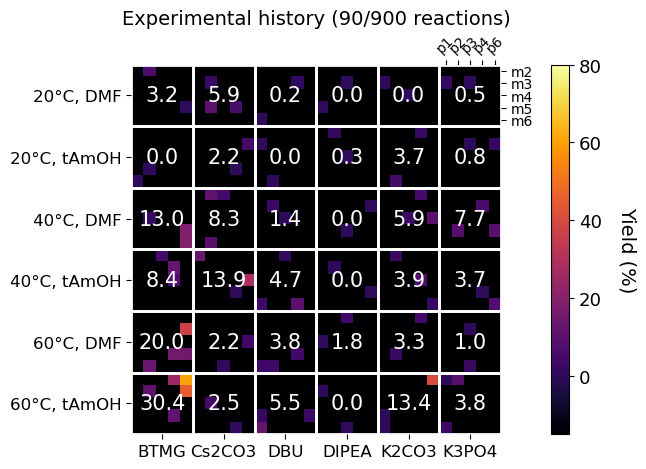

In [81]:
import pickle
import copy
import pandas as pd
import matplotlib.pyplot as plt 
from matplotlib.patches import Rectangle
import numpy as np
import itertools

# get all experimental data from the Scope object in the last round
with open('demo phenol alkylation/backups/round5-18/cache/scope.pkl', 'rb') as f:
    s = pickle.load(f)
df = copy.deepcopy(s.data)

df['yield'] = df['yield'].apply(lambda x: 100*x)
df['temperature'] = df['temperature'].apply(lambda x: x[1:]+'°C')
df['TS'] = df['temperature'] + ', ' + df['solvent_name']
df = df.sort_values(by=['base_name', 'TS', 'mesylate_id', 'phenol_id'])
df['yield'] = df['yield'].fillna(-20)

ts = df['TS'].unique()
bs = df['base_name'].unique()
ms = df['mesylate_id'].unique()
ps = df['phenol_id'].unique()
df = df.drop(['temperature', 'solvent_name', 'prediction'], axis=1)

# sort data into matrixes
ds = []
averages = []
for t, b in itertools.product(ts, bs):

    # get all data
    tempdf = df.loc[(df['TS'] == t) & (df['base_name'] == b)]
    tempdf = tempdf.drop(['TS', 'base_name'], axis=1)
    a = np.array(tempdf.groupby(by=['mesylate_id'], sort=True)['yield'].apply(list).to_list())
    # each row of a is a mesylate, each column of a is an phenol
    ds.append(a)

    # do average
    to_average = df.loc[(df['TS'] == t) & (df['base_name'] == b) & (df['yield'] != -20)]['yield'].to_numpy()
    if len(to_average) == 0:  # catch the np.average warning for empty array
        averages.append('n/a')
    else:
        averages.append(round(np.average(to_average), 1))

# could've written some recursive loop here, but was lazy
data = np.vstack([np.hstack(ds[0:6]),
                  np.hstack(ds[6:12]),
                  np.hstack(ds[12:18]),
                  np.hstack(ds[18:24]),
                  np.hstack(ds[24:30]),
                  np.hstack(ds[30:36]),
                  ])

# start plotting
fig, ax = plt.subplots()
im = ax.imshow(data, cmap='inferno', vmin=-15, vmax=80)

# average yield in the center of each block
text_kwargs = dict(ha='center', va='center', fontsize=15, color='white')
ii = 0
for i in range(6):
    for j in range(6):
        ax.add_patch(Rectangle((5 * j - 0.5, 5 * i - 0.5), 5, 5, fill=False, edgecolor='white', lw=2))
        plt.text(5 * j + 2, 5 * i + 2, averages[ii], **text_kwargs)
        ii = ii + 1

# set x axis (base name), y axis (temp, solvent) labels
tick_pos = [2, 7, 12, 17, 22, 27]
ax.set_xticks(tick_pos, bs, fontsize=12)
ax.set_yticks(tick_pos, ts, fontsize=12)

# add minor axes for phenol and mesylate names
ax_t = ax.secondary_xaxis('top')
ax_t.set_xticks(np.arange(5)+25, labels=ps, rotation=45)
ax_r = ax.secondary_yaxis('right')
ax_r.set_yticks(np.arange(5), labels=ms)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax_t.spines['top'].set_visible(False)
ax_r.spines['right'].set_visible(False)

cbar = plt.colorbar(im, pad=0.1)
cbar.ax.tick_params(labelsize=13)
cbar.ax.set_ylabel('Yield (%)', rotation=270, fontsize=14, labelpad=25)
plt.title(f'Experimental history (90/900 reactions)', fontsize=14)
#plt.tight_layout()
plt.rcParams['savefig.dpi'] = 300
plt.show()



**[Fig. S118]** Bar plot comparing different condition components' performance during optimization

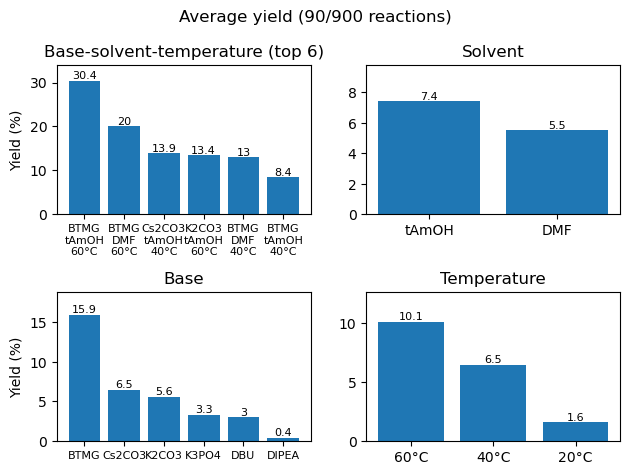

In [86]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('demo phenol alkylation/backups/round5-18/history.csv')
df['yield'] = df['yield']*100
df['temperature'] = df['temperature'].apply(lambda x: x[1:]+'°C')

figs, axes = plt.subplots(2, 2)

# all conditions
df['all'] = df['base_name']+('\n')+df['solvent_name']+'\n'+df['temperature']
fd = df.groupby('all')['yield'].mean().apply(lambda x: round(x, 1)).sort_values(ascending=False)[0:6]
p = axes[0, 0].bar(fd.index, fd.values)
b, t = axes[0,0].get_ylim()
axes[0, 0].set_ylim(b, t+2)
axes[0, 0].bar_label(p, label_type='edge', c='k', fontsize=8)
axes[0, 0].tick_params(axis='x', which='major', labelsize=8)
axes[0, 0].set_title('Base-solvent-temperature (top 6)')
axes[0, 0].set_ylabel('Yield (%)')

# base
fd = df.groupby('base_name')['yield'].mean().apply(lambda x: round(x, 1)).sort_values(ascending=False)
p = axes[1, 0].bar(fd.index, fd.values)
b, t = axes[1,0].get_ylim()
axes[1, 0].set_ylim(b, t+2)
axes[1, 0].bar_label(p, label_type='edge', c='k', fontsize=8)
axes[1, 0].tick_params(axis='x', which='major', labelsize=8)
axes[1, 0].set_title('Base')
axes[1, 0].set_ylabel('Yield (%)')

# solvent
fd = df.groupby('solvent_name')['yield'].mean().apply(lambda x: round(x, 1)).sort_values(ascending=False)
p = axes[0, 1].bar(fd.index, fd.values)
b, t = axes[0,1].get_ylim()
axes[0, 1].set_ylim(b, t+2)
axes[0, 1].bar_label(p, label_type='edge', c='k', fontsize=8)
#axes[0, 1].set_xticklabels(fd.index)
axes[0, 1].set_title('Solvent')

# temperature
fd = df.groupby('temperature')['yield'].mean().apply(lambda x: round(x, 1)).sort_values(ascending=False)
p = axes[1, 1].bar(fd.index, fd.values)
b, t = axes[1,1].get_ylim()
axes[1, 1].set_ylim(b, t+2)
axes[1, 1].bar_label(p, label_type='edge', c='k', fontsize=8)
#axes[1, 1].set_xticklabels(fd.index)
axes[1, 1].set_title('Temperature')

figs.suptitle('Average yield (90/900 reactions)')
plt.rcParams['savefig.dpi']=300
plt.tight_layout()
plt.show()

**[Fig. 6c]** We compared the performance of 'BTMG-tAmOH-60°C' with 'Cs2CO3-DMF-60°C' and 'K3PO4-DMF-60°C' when tested on 11 external substrates with phenol p5 and mesylate m1. This is a bar plot for each test substrate pairing, comparing thre conditions.

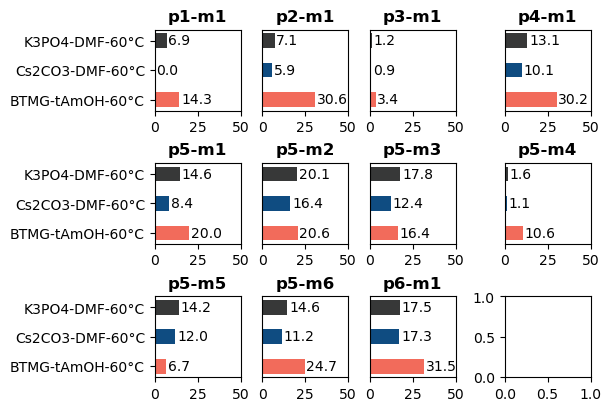

In [67]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv('demo phenol alkylation/misc/validation data.csv')
df['base-solvent-temp'] = df['base'] + '-' + df['solvent'] + '-' + df['temperature']
df['phenol-mesylate'] = df['phenol'] + '-' + df['mesylate']
df = df.sort_values(by=['phenol-mesylate', 'base-solvent-temp'])
data = df.groupby(by=['phenol-mesylate'])['yield'].apply(list)
ids = data.index

conditions = ['BTMG-tAmOH-60°C', 'Cs2CO3-DMF-60°C', 'K3PO4-DMF-60°C']

plt.rcParams['savefig.dpi'] = 300
fig, axs = plt.subplots(3, 4, figsize=(6,4), constrained_layout=True)

def ax_plot(x, y, data, title, y_ticks=False):
    colors = ['#f26b5b', '#0f4c81', '#373838']
    conditions = ['BTMG-tAmOH-60°C', 'Cs2CO3-DMF-60°C', 'K3PO4-DMF-60°C',]
    axs[x, y].barh(np.arange(len(data)), data, height=0.5, color=colors)
    for p, v in zip(np.arange(len(data)), data):
        axs[x, y].text(v+1, p, str(round(v,1)), ha='left', va='center', c='black')
    axs[x, y].set_title(title, fontweight='bold')  # title
    if y_ticks:  # y label
        axs[x, y].set_yticks(np.arange(len(data)), conditions)
    else:
        axs[x, y].set_yticks([])
    axs[x, y].set_xlim([0,50])

id_count = 0
for row in range(3):
    for column in range(4):
        if id_count in [0, 4, 8]:
            ax_plot(row, column, data.loc[ids[id_count]], title=ids[id_count], y_ticks=True)
        else:
            ax_plot(row, column, data.loc[ids[id_count]], title=ids[id_count])
        id_count += 1
        if id_count == 11:
            break

fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.show()

## Analysis of historical data at Bristol Myers Squibb
 
**[Fig. S119]** A strip plot analyzing past phenol alkylation condition selections at BMS. 

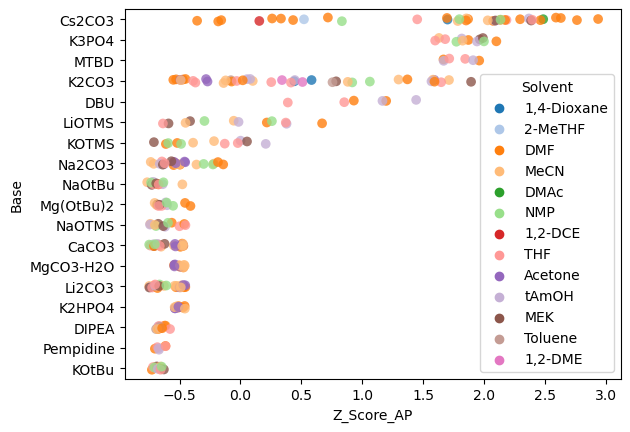

In [87]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['savefig.dpi'] = 300

# short names for some bases
df = pd.read_csv('demo phenol alkylation/misc/BMS history data.csv')
df['Base'] = df['Base'].apply(lambda x: 'DIPEA' if x == 'Diisopropylethylamine' else x)
df['Base'] = df['Base'].apply(lambda x: 'Pempidine' if x == 'Pentamethylipiperidine' else x)

# sort based on max Z-score AP achieved 
counts = df.groupby(by='Base')['Z_Score_AP'].max().sort_values(ascending=False)
order = list(counts.index)

df['Z_Score_AP'] = df['Z_Score_AP'].apply(lambda x: x + np.random.rand()/10)

sns.stripplot(data=df, x='Z_Score_AP', y='Base',
              hue='Solvent',
              alpha=0.8,
              size=7,
              palette='tab20',
              order=order)
plt.show()